In [39]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

%matplotlib inline

In [26]:
input_df = '../dataframes/h3n2_ha_12y_hi.csv'
df_name = str.split(input_df, 'dataframes/')[1]
prefix = str.split(df_name, '.csv')[0]
pre_prefix = str.split(prefix, '_hi')[0]

/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0,0.5,'log2(egg titer)-log2(paired titer)'), Text(0.5,0,'')]

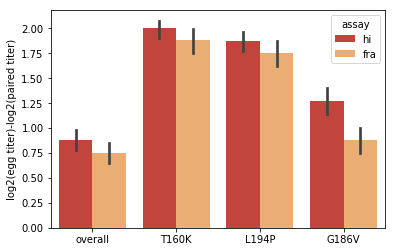

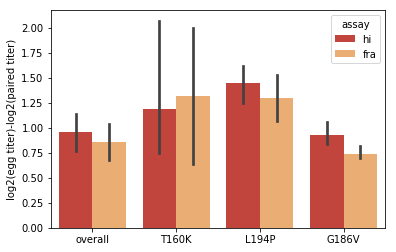

In [37]:
muts_to_consider = ['T160K', 'G186V', 'L194P']
titer_diffs_singlemut = []
titer_diffs = []
for assay in ['hi', 'fra']:
    all_df = pd.read_csv('../dataframes/'+pre_prefix+"_"+assay+'.csv')
    df = all_df[all_df['pair_id']!=0]

    #Re-organize DF to one row per pair
    sub_egg = df[df['passage']=='egg'][['source', 'egg_muts', 'cTiterSub']].rename(columns = {'cTiterSub':'egg_titer'})
    sub_u = df[df['passage']=='unpassaged'][['source', 'cTiterSub']].rename(columns = {'cTiterSub':'pair_titer'})
    sub_cell = df[df['passage']=='cell'][['source', 'cTiterSub']].rename(columns = {'cTiterSub':'pair_titer'})

    pairs_u_df = sub_egg.merge(sub_u)
    pairs_cell_df = sub_egg.merge(sub_cell)
    pairs_cell_u_df = sub_u.merge(sub_cell)
    pairs_df = pairs_u_df.merge(pairs_cell_df, how='outer')

    for k,v in pairs_df.iterrows():
        if len(ast.literal_eval(v['egg_muts']))==1:
            diff = v['egg_titer'] - v['pair_titer']
            titer_diffs_singlemut.append({'mutation':'overall', 'titer_diff': diff, 'assay': assay})
            for egg_mut in muts_to_consider:
                if egg_mut in ast.literal_eval(v['egg_muts']):
                    titer_diff = v['egg_titer'] - v['pair_titer']
                    titer_diffs_singlemut.append({'mutation': egg_mut, 'titer_diff': titer_diff, 'assay': assay})
        else:
            diff = v['egg_titer'] - v['pair_titer']
            titer_diffs.append({'mutation':'overall', 'titer_diff': diff, 'assay': assay})
            for egg_mut in muts_to_consider:
                if egg_mut in ast.literal_eval(v['egg_muts']):
                    titer_diff = v['egg_titer'] - v['pair_titer']
                    titer_diffs.append({'mutation': egg_mut, 'titer_diff': titer_diff, 'assay': assay})

titer_diffs_df = pd.DataFrame(titer_diffs)
titer_diffs_singlemut_df = pd.DataFrame(titer_diffs_singlemut)

#Total antigenic change in viruses that have these mutations 
fig, ax = plt.subplots()
fig = sns.barplot(x='mutation', y='titer_diff', hue='assay', order=['overall', 'T160K', 'L194P', 'G186V'], data=titer_diffs_df, palette= ['#d73027', '#fdae61'])
ax.set(xlabel = '', ylabel='log2(egg titer)-log2(paired titer)')

#Antigenic effect of single mutation
fig2, ax2 = plt.subplots()
fig2 = sns.barplot(x='mutation', y='titer_diff', hue='assay', order=['overall', 'T160K', 'L194P', 'G186V'], data=titer_diffs_singlemut_df, palette= ['#d73027', '#fdae61'])
ax2.set(xlabel = '', ylabel='log2(egg titer)-log2(paired titer)')
    

In [38]:
titer_diffs_df.groupby(['mutation', 'assay'])['titer_diff'].mean()

mutation  assay
G186V     fra      0.880035
          hi       1.275350
L194P     fra      1.749521
          hi       1.869459
T160K     fra      1.880651
          hi       1.999826
overall   fra      0.749290
          hi       0.878507
Name: titer_diff, dtype: float64

In [43]:
titer_diffs_singlemut_df.groupby(['mutation', 'assay'])['titer_diff'].mean()

mutation  assay
G186V     fra      0.735640
          hi       0.927103
L194P     fra      1.299669
          hi       1.447475
T160K     fra      1.318143
          hi       1.189658
overall   fra      0.859075
          hi       0.960539
Name: titer_diff, dtype: float64

In [51]:
#stats for all muts
titer_stats = []
muts_to_consider = ['overall','T160K', 'G186V', 'L194P']
for mut1 in muts_to_consider:
    for mut2 in muts_to_consider[muts_to_consider.index(mut1)+1:]:
        for assay in ['hi', 'fra']:
            cat1 = titer_diffs_df[(titer_diffs_df['assay']==assay)&(titer_diffs_df['mutation']==mut1)]
            cat2 = titer_diffs_df[(titer_diffs_df['assay']==assay)&(titer_diffs_df['mutation']==mut2)]
            pvalue = ttest_ind(cat1['titer_diff'], cat2['titer_diff']).pvalue
            titer_stats.append({'assay': assay, 'mut1': mut1, 'mut2': mut2, 'pvalue': pvalue})
        
titer_stats_df = pd.DataFrame(titer_stats)
titer_stats_df


,assay,mut1,mut2,pvalue
0,hi,overall,T160K,2.421375e-20
1,fra,overall,T160K,1.268044e-19
2,hi,overall,G186V,3.474145e-04
3,fra,overall,G186V,2.144250e-01
4,hi,overall,L194P,5.765137e-20
5,fra,overall,L194P,1.048592e-20
6,hi,T160K,G186V,1.293110e-14
7,fra,T160K,G186V,2.078338e-19
8,hi,T160K,L194P,6.412428e-02
9,fra,T160K,L194P,1.581694e-01


In [49]:
#stats for single muts
titer_stats_singlemut = []
muts_to_consider = ['overall','T160K', 'G186V', 'L194P']
for mut1 in muts_to_consider:
    for mut2 in muts_to_consider[muts_to_consider.index(mut1)+1:]:
        for assay in ['hi', 'fra']:
            cat1 = titer_diffs_singlemut_df[(titer_diffs_singlemut_df['assay']==assay)&(titer_diffs_singlemut_df['mutation']==mut1)]
            cat2 = titer_diffs_singlemut_df[(titer_diffs_singlemut_df['assay']==assay)&(titer_diffs_singlemut_df['mutation']==mut2)]
            pvalue = ttest_ind(cat1['titer_diff'], cat2['titer_diff']).pvalue
            titer_stats_singlemut.append({'assay': assay, 'mut1': mut1, 'mut2': mut2, 'pvalue': pvalue})
        
titer_stats_singlemut_df = pd.DataFrame(titer_stats_singlemut)
titer_stats_singlemut_df

    

,assay,mut1,mut2,pvalue
0,hi,overall,T160K,0.634938
1,fra,overall,T160K,0.418986
2,hi,overall,G186V,0.868365
3,fra,overall,G186V,0.534984
4,hi,overall,L194P,0.001320
5,fra,overall,L194P,0.005471
6,hi,T160K,G186V,0.241256
7,fra,T160K,G186V,0.015018
8,hi,T160K,L194P,0.460353
9,fra,T160K,L194P,0.974002
